In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
from tqdm import tqdm
import torch
import logging
import re
import string

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alger\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alger\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alger\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [196]:
# Global variables
master_df = pd.read_csv("jpm_nii_data.csv")
gpt4_df = pd.read_csv("jpm_nii_gpt-4o_sentiment_analysis.csv")
exclude_words = {'management', 'commentary', 'rotce', 'net', 'interest', 'income','nii','think','question','year','billion','youre'}

# Convert all column names in master_df and gpt4_df to lowercase and strip whitespace
master_df.columns = master_df.columns.str.lower().str.strip()
gpt4_df.columns = gpt4_df.columns.str.lower().str.strip()

master_df

,question,answer,analyst,respondent,quarter,ratio
0,Management Commentary,Declines in net interest income were largely o...,Management Commentary,Jeremy Barnum,2020Q4,13258
1,"So, I want to start off with a question on the...","Sure. So, I'll start with excess liquidity. So...",Steven Chubak,"Jamie Dimon, Jennifer A. Piepszak",2020Q4,13258
2,"Hi, Jenn. Given the outlook for net interest i...","Sure. So, I'll start by saying you're absolute...",John E. McDonald,Jennifer A. Piepszak,2020Q4,13258
3,"Okay. And then as a follow-up, on the NII walk...","Yes, it can absolutely be true. So, Markets is...",John E. McDonald,"Jamie Dimon, Jennifer A. Piepszak",2020Q4,13258
4,Management Commentary,So you can see that we do expect to be able to...,Management Commentary,Jeremy Barnum,2020Q4,13258
...,...,...,...,...,...,...
227,Management Commentary,5 billion and total NII to be approximately $92.,Management Commentary,Jeremy Barnum,2024Q3,23405
228,Management Commentary,"And given where we are in the year, we include...",Management Commentary,Jeremy Barnum,2024Q3,23405
229,Management Commentary,NII was $2.,Management Commentary,Jeremy Barnum,2024Q3,23405
230,Hey. Good morning. I'm not going to ask about ...,"Sure. Yeah, thanks for the question, Saul. And...",Saul Martinez,"Jamie Dimon, Jeremy Barnum",2024Q3,23405


In [197]:
class ReportAnalyzer:
    def __init__(self, master_df):
        """
        Initializes the ReportAnalyzer with the provided DataFrame.

        Parameters:
        master_df (pd.DataFrame): The DataFrame containing the report data.
        """
        self.master_df = master_df.copy()
        self._ensure_numeric_ratio()
        self._add_question_type()
        self._compute_quarterly_counts()
        self._compute_average_ratio()
        self._compute_ratio_deltas()

    def _ensure_numeric_ratio(self):
        """
        Ensures that the 'ratio' column is numeric by removing '%' and converting to float.
        Handles cases where 'ratio' might already be numeric or contain unexpected formats.
        """
        if 'ratio' not in self.master_df.columns:
            raise ValueError("The DataFrame does not contain a 'ratio' column.")

        # Check if 'ratio' is of object type (likely strings with '%')
        if self.master_df['ratio'].dtype == object:
            # Remove '%' and any surrounding whitespace, then convert to float
            self.master_df['ratio'] = self.master_df['ratio'].str.replace('%', '').str.strip()

            # Handle potential non-convertible values
            try:
                self.master_df['ratio'] = self.master_df['ratio'].astype(float)
            except ValueError as e:
                raise ValueError("Conversion to float failed for 'ratio' column. Ensure all entries are numeric or end with '%'.") from e
        else:
            # If already numeric, ensure it's float type
            self.master_df['ratio'] = self.master_df['ratio'].astype(float)

    def _add_question_type(self):
        """
        Adds a 'question_type' column to the DataFrame to categorize questions.
        """
        if 'question' not in self.master_df.columns:
            raise ValueError("The DataFrame does not contain a 'question' column.")

        self.master_df['question_type'] = self.master_df['question'].apply(
            lambda x: 'management commentary' if isinstance(x, str) and x.lower() == 'management commentary' else 'question'
        )

    def _compute_quarterly_counts(self):
        """
        Groups the DataFrame by 'quarter' and 'question_type' to get counts.
        """
        if 'quarter' not in self.master_df.columns:
            raise ValueError("The DataFrame does not contain a 'quarter' column.")

        self.quarterly_counts = self.master_df.groupby(['quarter', 'question_type']).size().unstack(fill_value=0)
        self.quarterly_counts = self.quarterly_counts.sort_index()  # Ensure quarters are sorted

    def _compute_average_ratio(self):
        """
        Groups the DataFrame by 'quarter' to calculate the average 'ratio'.
        """
        if 'quarter' not in self.master_df.columns or 'ratio' not in self.master_df.columns:
            raise ValueError("The DataFrame must contain both 'quarter' and 'ratio' columns.")

        self.average_ratio = self.master_df.groupby('quarter')['ratio'].mean()
        self.average_ratio = self.average_ratio.sort_index()  # Ensure quarters are sorted

    def _compute_ratio_deltas(self):
        """
        Calculates ratio_delta and forward_ratio_delta.
        - ratio_delta: Current ratio minus previous quarter's ratio.
        - forward_ratio_delta: Next quarter's ratio minus current ratio.
        """
        # Calculate ratio_delta
        self.ratio_delta = self.average_ratio.diff()
        
        # Calculate forward_ratio_delta
        self.forward_ratio_delta = self.average_ratio.shift(-1) - self.average_ratio

    def plot_report(self):
        """
        Plots the frequency of questions and the ratio deltas.
        """
        # Plot frequency and deltas using ReportAnalyzer's computed data
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharex=True)

        # Plot on the first subplot: ratio_delta
        self.quarterly_counts.plot(kind='area', stacked=True, ax=ax1, alpha=0.6)
        ax1.set_title("Frequency of Questions and Change in Metric per Quarter")
        ax1.set_xlabel("Quarter")
        ax1.set_ylabel("Row Count")
        ax1.grid(False)  # Remove grid

        # Create secondary y-axis for ratio_delta
        ax1_delta = ax1.twinx()
        ax1_delta.plot(
            self.ratio_delta.index,
            self.ratio_delta,
            color='red',
            marker='o',
            label='Metric Delta'
        )
        ax1_delta.set_ylabel("Metric Delta")
        ax1_delta.legend(loc='upper right')

        # Combine legends for the first plot
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax1_delta.get_legend_handles_labels()
        ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper left')

        # Plot on the second subplot: forward_ratio_delta
        self.quarterly_counts.plot(kind='area', stacked=True, ax=ax2, alpha=0.6)
        ax2.set_title("Frequency of Questions and Forward Change in Metric per Quarter")
        ax2.set_xlabel("Quarter")
        ax2.set_ylabel("Row Count")
        ax2.grid(False)  # Remove grid

        # Create secondary y-axis for forward_ratio_delta
        ax2_forward_delta = ax2.twinx()
        ax2_forward_delta.plot(
            self.forward_ratio_delta.index,
            self.forward_ratio_delta,
            color='red',
            marker='o',
            label='Forward Metric Delta'
        )
        ax2_forward_delta.set_ylabel("Forward Metric Delta")
        ax2_forward_delta.legend(loc='upper right')

        # Combine legends for the second plot
        handles3, labels3 = ax2.get_legend_handles_labels()
        handles4, labels4 = ax2_forward_delta.get_legend_handles_labels()
        ax2.legend(handles=handles3 + handles4, labels=labels3 + labels4, loc='upper left')

        plt.tight_layout()
        plt.show()

In [198]:
class TextPreprocessor:
    def __init__(self):
        """
        Initializes the TextPreprocessor with necessary NLP tools.
        """
        # Define stop words
        self.stop_words = set(stopwords.words('english'))
        
        # Initialize lemmatizer
        self.lemmatizer = WordNetLemmatizer()
    
    def preprocess_text(self, text):
        """
        Preprocesses the input text by:
        - Converting to lowercase
        - Removing hyphens
        - Removing numbers
        - Removing punctuation and specific characters
        - Removing stop words and single-letter words
        
        Parameters:
        - text (str): The text to preprocess.
        
        Returns:
        - str: The preprocessed text.
        """
        if pd.isnull(text):
            return text  # Return NaN as is
        
        # Convert to lowercase
        text = text.lower()
        
        # Replace hyphens with spaces to separate hyphenated words
        text = text.replace('-', ' ')
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove punctuation and specific unwanted characters
        text = text.translate(str.maketrans('', '', string.punctuation + '’'))
        
        # Remove stop words and single-letter words
        text = ' '.join([word for word in text.split() if word not in self.stop_words and len(word) > 1])
        
        return text
    
    def tokenize_text(self, text):
        """
        Tokenizes the input text into words.
        
        Parameters:
        - text (str): The text to tokenize.
        
        Returns:
        - list: A list of word tokens.
        """
        if pd.isnull(text):
            return text  # Return NaN as is
        
        return word_tokenize(text)
    
    def lemmatize_tokens(self, tokens):
        """
        Lemmatizes a list of word tokens.
        
        Parameters:
        - tokens (list): A list of word tokens.
        
        Returns:
        - list: A list of lemmatized tokens.
        """
        if isinstance(tokens, list):
            return [self.lemmatizer.lemmatize(token) for token in tokens]
        return tokens  # Return NaN or other non-list types as is
    
    def lowercase_columns(self, df, exclude_columns):
        """
        Converts all string entries in the DataFrame to lowercase,
        excluding specified columns.
        
        Parameters:
        - df (pd.DataFrame): The DataFrame to process.
        - exclude_columns (list): List of column names to exclude from lowercasing.
        
        Returns:
        - pd.DataFrame: The DataFrame with specified columns lowercased.
        """
        # Identify string columns excluding specified columns
        string_columns = df.select_dtypes(include=['object', 'string']).columns.tolist()
        string_columns = [col for col in string_columns if col not in exclude_columns]
        
        # Convert all string entries in the identified columns to lowercase
        df[string_columns] = df[string_columns].apply(lambda col: col.str.lower())
        
        return df
    
    def process_dataframe(self, df):
        """
        Processes the input DataFrame by:
        - Preprocessing 'question' and 'answer' columns
        - Tokenizing the preprocessed text
        - Lemmatizing the tokens
        - Dropping specified columns
        - Renaming lemmatized columns to lowercase
        
        Parameters:
        - df (pd.DataFrame): The DataFrame to process.
        
        Returns:
        - pd.DataFrame: The processed DataFrame with new columns.
        """
        # Preprocess
        df['processed_question'] = df['question'].apply(self.preprocess_text)
        df['processed_answer'] = df['answer'].apply(self.preprocess_text)
        
        # Tokenize
        df['tokenized_question'] = df['processed_question'].apply(self.tokenize_text)
        df['tokenized_answer'] = df['processed_answer'].apply(self.tokenize_text)
        
        # Lemmatize
        df['lemmatized_question'] = df['tokenized_question'].apply(self.lemmatize_tokens)
        df['lemmatized_answer'] = df['tokenized_answer'].apply(self.lemmatize_tokens)
        
        # Drop intermediate processed columns and tokenized columns
        columns_to_drop = [
            'processed_question',
            'processed_answer',
            'tokenized_question',
            'tokenized_answer'
        ]
        # Ensure that only existing columns are dropped to avoid errors
        columns_to_drop = [col for col in columns_to_drop if col in df.columns]
        df = df.drop(columns=columns_to_drop)
        
        # Rename lemmatized columns to lowercase, ensuring no duplicates
        rename_mapping = {
            'lemmatized_question': 'lemmatized_question',
            'lemmatized_answer': 'lemmatized_answer'
        }
        df = df.rename(columns=rename_mapping)
        
        return df

In [199]:
class WordFrequencyAnalyzer:
    def __init__(self, tokenized_questions, tokenized_answers, exclude_words=exclude_words):
        """
        Initializes the WordFrequencyAnalyzer with tokenized questions and answers.

        Parameters:
        tokenized_questions (list of lists): Tokenized words from questions.
        tokenized_answers (list of lists): Tokenized words from answers.
        exclude_words (set): Words to exclude from the analysis.
        """
        self.tokenized_questions = tokenized_questions
        self.tokenized_answers = tokenized_answers
        self.exclude_words = exclude_words

    def calculate_word_frequencies(self, tokenized_comments):
        """
        Calculate word frequencies, excluding specified words.

        Parameters:
        tokenized_comments (list of lists): List of tokenized comments (questions or answers).

        Returns:
        nltk.probability.FreqDist: Frequency distribution of words.
        """
        # Flatten the list of tokenized comments and filter out unwanted words
        all_words = [word for tokens in tokenized_comments for word in tokens if word.lower() not in self.exclude_words]
        # Calculate frequency distribution
        freq_dist = FreqDist(all_words)
        return freq_dist

    def generate_wordcloud(self, freq_dist):
        """
        Generates a word cloud from a frequency distribution.

        Parameters:
        freq_dist (nltk.probability.FreqDist): Frequency distribution of words.

        Returns:
        WordCloud: Generated word cloud.
        """
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)
        return wordcloud

    def plot_top_words_histogram(self, freq_dist, title, ax):
        """
        Plots a histogram of the top 10 words.

        Parameters:
        freq_dist (nltk.probability.FreqDist): Frequency distribution of words.
        title (str): Title for the subplot.
        ax (matplotlib.axes._subplots.AxesSubplot): Axis to plot the histogram on.
        """
        top_words = freq_dist.most_common(10)
        words, frequencies = zip(*top_words)
        ax.bar(words, frequencies, color='skyblue')
        ax.set_xlabel('Words')
        ax.set_ylabel('Frequency')
        ax.set_title(title)
        ax.set_xticks(range(len(words)))
        ax.set_xticklabels(words, rotation=45)

    def analyze(self):
        """
        Calculates word frequencies, generates word clouds, and displays both word clouds and top word histograms.
        """
        # Combine questions and answers for total analysis
        combined_words = self.tokenized_questions + self.tokenized_answers

        # Calculate frequency distributions
        question_freq_dist = self.calculate_word_frequencies(self.tokenized_questions)
        answer_freq_dist = self.calculate_word_frequencies(self.tokenized_answers)
        total_freq_dist = self.calculate_word_frequencies(combined_words)

        # Generate word clouds
        question_wordcloud = self.generate_wordcloud(question_freq_dist)
        answer_wordcloud = self.generate_wordcloud(answer_freq_dist)
        total_wordcloud = self.generate_wordcloud(total_freq_dist)

        # Display word clouds
        self._display_wordclouds(question_wordcloud, answer_wordcloud, total_wordcloud)

        # Display histograms of top words
        self._display_top_words_histograms(question_freq_dist, answer_freq_dist, total_freq_dist)

    def _display_wordclouds(self, question_wordcloud, answer_wordcloud, total_wordcloud):
        """
        Displays the word clouds side by side.

        Parameters:
        question_wordcloud (WordCloud): Word cloud for questions.
        answer_wordcloud (WordCloud): Word cloud for answers.
        total_wordcloud (WordCloud): Word cloud for combined text.
        """
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))

        # Plot each word cloud in a subplot
        axes[0].imshow(question_wordcloud, interpolation='bilinear')
        axes[0].set_title('Question Word Cloud')
        axes[0].axis('off')

        axes[1].imshow(answer_wordcloud, interpolation='bilinear')
        axes[1].set_title('Answer Word Cloud')
        axes[1].axis('off')

        axes[2].imshow(total_wordcloud, interpolation='bilinear')
        axes[2].set_title('Combined Word Cloud')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

    def _display_top_words_histograms(self, question_freq_dist, answer_freq_dist, total_freq_dist):
        """
        Displays histograms of the top 10 words in questions, answers, and combined text.

        Parameters:
        question_freq_dist (FreqDist): Frequency distribution for question words.
        answer_freq_dist (FreqDist): Frequency distribution for answer words.
        total_freq_dist (FreqDist): Frequency distribution for combined words.
        """
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))

        # Plot each histogram in a separate subplot
        self.plot_top_words_histogram(question_freq_dist, 'Top 10 Words in Questions', axes[0])
        self.plot_top_words_histogram(answer_freq_dist, 'Top 10 Words in Answers', axes[1])
        self.plot_top_words_histogram(total_freq_dist, 'Top 10 Words in Combined Text', axes[2])

        plt.tight_layout()
        plt.show()

LLM sentiment analyser

In [200]:
class FinancialSentimentAnalyzer:
    def __init__(self, model_name="ProsusAI/finbert"):
        self.model_name = model_name
        self.model_short_name = self.model_name.split('/')[-1]  # Extract model name after '/'
        self.tokenizer = None
        self.model = None
        self.nlp = None
        self._initialize_model()
    
    def _initialize_model(self):
        """Private method to load model and tokenizer"""
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name)
        self.nlp = pipeline(
            "sentiment-analysis",
            model=self.model,
            tokenizer=self.tokenizer,
            device=0 if torch.cuda.is_available() else -1  # Utilize GPU if available
        )
    
    def analyze_texts(self, texts, batch_size=32, max_length=512):
        """
        Analyze a list of texts and return their sentiments and confidence scores.

        Args:
            texts (List[str]): List of texts to analyze.
            batch_size (int): Number of texts to process in a batch.
            max_length (int): Maximum length of each text.

        Returns:
            List[str], List[float]: Lists of sentiments and confidence scores.
        """
        # Mapping for standardizing labels based on finbert-pretrain
        label_mapping = {
            "LABEL_0": "neutral",   # Neutral
            "LABEL_1": "positive",  # Positive
            "LABEL_2": "negative"   # Negative
        }

        # Ensure texts are strings and handle length
        processed_texts = [text[:max_length] if isinstance(text, str) else '' for text in texts]
        
        # Use the pipeline to process texts in batches
        results = self.nlp(processed_texts, batch_size=batch_size)
        
        # If the pipeline returns a single result as dict, wrap it in a list
        if isinstance(results, dict):
            results = [results]
        
        # Extract sentiments and confidence scores, applying label mapping
        sentiments = [label_mapping.get(result['label'], "neutral") for result in results]
        confidences = [result['score'] for result in results]
        
        return sentiments, confidences
    
    def analyze_dataframe(self, df, question_column, answer_column):
        """
        Analyze sentiment for specified question and answer columns in the dataframe.

        Args:
            df (pd.DataFrame): The dataframe containing the data.
            question_column (str): Column name for questions.
            answer_column (str): Column name for answers.

        Returns:
            pd.DataFrame: DataFrame with added sentiment and confidence columns.
        """
        # Convert lists to strings if necessary
        def convert_to_string(x):
            if isinstance(x, list):
                return ' '.join(x)
            elif isinstance(x, str):
                return x
            else:
                return ''
        
        df = df.copy()  # To avoid modifying the original dataframe
        
        # Prepare question texts
        temp_question_text_col = "__temp_question_text"
        df[temp_question_text_col] = df[question_column].apply(convert_to_string)
        
        # Prepare answer texts
        temp_answer_text_col = "__temp_answer_text"
        df[temp_answer_text_col] = df[answer_column].apply(convert_to_string)
        
        # Analyze question sentiments
        tqdm.pandas(desc=f"Analyzing {self.model_short_name} Sentiments for {question_column}")
        question_texts = df[temp_question_text_col].tolist()
        question_sentiments, question_confidences = self.analyze_texts(question_texts)
        
        # Analyze answer sentiments
        tqdm.pandas(desc=f"Analyzing {self.model_short_name} Sentiments for {answer_column}")
        answer_texts = df[temp_answer_text_col].tolist()
        answer_sentiments, answer_confidences = self.analyze_texts(answer_texts)
        
        # Assign results to new columns with simplified model names and dynamic column names
        df[f"{self.model_short_name}_{question_column}_sentiment"] = question_sentiments
        df[f"{self.model_short_name}_{question_column}_confidence"] = question_confidences
        df[f"{self.model_short_name}_{answer_column}_sentiment"] = answer_sentiments
        df[f"{self.model_short_name}_{answer_column}_confidence"] = answer_confidences
        
        # Drop temporary columns
        df.drop(columns=[temp_question_text_col, temp_answer_text_col], inplace=True)
        
        return df
    
    def _handle_error(self, error):
        """Private method for error handling"""
        logging.error(f"Error in sentiment analysis: {error}")
    
    @property
    def model_info(self):
        """Property to get model information"""
        return {
            'model_name': self.model_name,
            'model_short_name': self.model_short_name,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu'
        }


#### EDA

In [201]:
class SentimentPlotter:
    def __init__(self, dataframe, sentiment_categories=None, 
                 answer_sentiment_substring='answer_sentiment',
                 question_sentiment_substring='question_sentiment',
                 exclude_question_text='Management Commentary'):
        """
        Initializes the SentimentAnalyzer with the dataframe and configuration parameters.
        
        Parameters:
        - dataframe (pd.DataFrame): The dataframe containing the data.
        - sentiment_categories (list): List of sentiment categories to consider.
                                       Defaults to ['positive', 'negative', 'neutral'].
        - answer_sentiment_substring (str): Substring to identify answer sentiment columns.
        - question_sentiment_substring (str): Substring to identify question sentiment columns.
        - exclude_question_text (str): Text to exclude in question filtering.
        """
        self.master_df = dataframe.copy()
        self.sentiment_categories = sentiment_categories if sentiment_categories else ['positive', 'negative', 'neutral']
        self.answer_sentiment_substring = answer_sentiment_substring
        self.question_sentiment_substring = question_sentiment_substring
        self.exclude_question_text = exclude_question_text
        
        # Identify sentiment columns upon initialization
        self.answer_sentiment_cols = self._identify_sentiment_columns(self.answer_sentiment_substring)
        self.question_sentiment_cols = self._identify_sentiment_columns(self.question_sentiment_substring)
    
    def _identify_sentiment_columns(self, substring):
        """
        Identifies columns containing the specified substring.
        
        Parameters:
        - substring (str): Substring to search for in column names.
        
        Returns:
        - list: List of column names containing the substring.
        """
        cols = [col for col in self.master_df.columns if substring in col]
        return cols
    
    def _process_sentiment_column(self, sentiment_col, exclude_question=False):
        """
        Processes a single sentiment column by filtering, counting, and normalizing.
        
        Parameters:
        - sentiment_col (str): The sentiment column to process.
        - exclude_question (bool): Whether to exclude specific questions.
        
        Returns:
        - pd.DataFrame: DataFrame with normalized sentiment percentages per quarter for the specified column.
        """
        df = self.master_df.copy()
        
        if exclude_question:
            # Exclude rows where 'question' contains the exclude text (case-insensitive)
            df = df[~df['question'].str.contains(self.exclude_question_text, case=False, na=False)]
        
        if sentiment_col not in df.columns:
            return pd.DataFrame()
        
        # Select relevant columns
        df_subset = df[['quarter', sentiment_col]].copy()
        
        # Drop rows with NaN sentiments
        df_subset = df_subset.dropna(subset=[sentiment_col])
        
        # Count sentiments per quarter
        sentiment_counts = df_subset.groupby('quarter')[sentiment_col].value_counts().unstack(fill_value=0)
        
        # Ensure all sentiment categories are present
        for sentiment in self.sentiment_categories:
            if sentiment not in sentiment_counts.columns:
                sentiment_counts[sentiment] = 0
        
        # Reorder columns to match sentiment_categories
        sentiment_counts = sentiment_counts[self.sentiment_categories]
        
        # Normalize counts to percentages per quarter
        sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0).multiply(100).fillna(0)
        sentiment_percentages.reset_index(inplace=True)
        
        return sentiment_percentages
    
    def get_sentiment_percentages(self, sentiment_col, exclude_question=False):
        """
        Retrieves the sentiment percentages for a specific sentiment column.
        
        Parameters:
        - sentiment_col (str): The sentiment column to process.
        - exclude_question (bool): Whether to exclude specific questions.
        
        Returns:
        - pd.DataFrame: DataFrame with normalized sentiment percentages per quarter for the specified column.
        """
        return self._process_sentiment_column(sentiment_col, exclude_question)
    
    def _calculate_grid_size(self, n):
        """
        Calculates the number of rows and columns for subplots based on the number of plots.
        
        Parameters:
        - n (int): Number of subplots.
        
        Returns:
        - (int, int): Number of rows and columns.
        """
        if n == 0:
            return (0, 0)
        cols = math.ceil(math.sqrt(n))
        rows = math.ceil(n / cols)
        return (rows, cols)
    
    def plot_sentiment_distributions(self, save_path_questions=None, save_path_answers=None):
        """
        Plots the sentiment distributions for each sentiment column as separate stacked bar charts,
        grouped into two main figures: one for questions and one for answers.
        
        Parameters:
        - save_path_questions (str): Optional path to save the questions plot image.
        - save_path_answers (str): Optional path to save the answers plot image.
        
        Returns:
        - None
        """
        sns.set(style="whitegrid")
        
        # Plot Question Sentiments
        self._plot_sentiment_type(
            sentiment_cols=self.question_sentiment_cols,
            exclude_question=True,
            title_prefix="Question Sentiment",
            save_path=save_path_questions,
            sentiment_type='Questions'
        )
        
        # Plot Answer Sentiments
        self._plot_sentiment_type(
            sentiment_cols=self.answer_sentiment_cols,
            exclude_question=False,
            title_prefix="Answer Sentiment",
            save_path=save_path_answers,
            sentiment_type='Answers'
        )
    
    def _plot_sentiment_type(self, sentiment_cols, exclude_question, title_prefix, save_path, sentiment_type):
        """
        Plots sentiment distributions for a specific type (questions or answers).
        
        Parameters:
        - sentiment_cols (list): List of sentiment columns to plot.
        - exclude_question (bool): Whether to exclude specific questions.
        - title_prefix (str): Prefix for subplot titles.
        - save_path (str): Path to save the plot image.
        - sentiment_type (str): Type of sentiment ('Questions' or 'Answers').
        
        Returns:
        - None
        """
        n_cols = len(sentiment_cols)
        if n_cols == 0:
            return
        
        # Calculate grid size
        rows, cols = self._calculate_grid_size(n_cols)
        
        # Create a figure with the calculated grid size
        fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows), squeeze=False)
        fig.suptitle(f"Sentiment Distribution for {sentiment_type}", fontsize=16)
        
        # Flatten axes for easy iteration
        axes_flat = axes.flatten()
        
        for idx, sentiment_col in enumerate(sentiment_cols):
            ax = axes_flat[idx]
            sentiment_data = self.get_sentiment_percentages(sentiment_col, exclude_question=exclude_question)
            
            if sentiment_data.empty:
                ax.text(0.5, 0.5, 'No Data Available', horizontalalignment='center',
                        verticalalignment='center', fontsize=14, color='red')
                ax.set_title(f"{sentiment_col} ({sentiment_type})")
                ax.set_xlabel('Quarter')
                ax.set_ylabel('Percentage (%)')
                ax.set_ylim(0, 100)
                ax.set_xticks([])
                continue
            
            # Define colors for each sentiment
            colors = {
                'positive': '#2ca02c',  # Green
                'negative': '#d62728',  # Red
                'neutral': '#1f77b4'    # Blue
            }
            
            # Plot stacked bar chart
            bottoms = np.zeros(len(sentiment_data))
            for sentiment in self.sentiment_categories:
                ax.bar(sentiment_data['quarter'], sentiment_data[sentiment], bottom=bottoms, 
                       label=sentiment.capitalize(), color=colors.get(sentiment, None))
                bottoms += sentiment_data[sentiment].values
            
            # Set titles and labels
            ax.set_title(f"{sentiment_col} ({sentiment_type})", fontsize=12)
            ax.set_xlabel('Quarter', fontsize=10)
            ax.set_ylabel('Percentage (%)', fontsize=10)
            ax.set_ylim(0, 100)
            ax.legend(title='Sentiment', fontsize=8, title_fontsize=10)
            ax.tick_params(axis='x', rotation=45)
        
        # Hide any unused subplots
        for idx in range(n_cols, rows * cols):
            axes_flat[idx].axis('off')
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save the figure if a path is provided
        if save_path:
            plt.savefig(save_path)
        
        plt.show()

#### Aggregating Scores for every quarter

In [202]:
class ConcatenateToQuarter:
    """
    A class to process a master DataFrame containing sentiment and confidence scores
    from various models and aggregate them into a quarterly summary with weighted
    average sentiment scores.
    """
    
    def __init__(self, master_df, sentiment_mapping=None):
        """
        Initializes the ConcatenateToQuarter instance.
        
        Parameters:
            master_df (pd.DataFrame): The master DataFrame containing sentiment and confidence columns.
            sentiment_mapping (dict, optional): A dictionary to map sentiment strings to numerical values.
                                                If None, a default mapping is used:
                                                    {'negative': -1, 'neutral': 0, 'positive': 1}
        """
        self.master_df = master_df.copy()
        self.sentiment_cols = []
        self.confidence_cols = []
        self.model_names = set()
        self.weighted_sentiments = pd.DataFrame()
        self.quarter_df = pd.DataFrame()
        self.sentiment_mapping = sentiment_mapping or {'negative': -1, 'neutral': 0, 'positive': 1}
        
    def _identify_columns(self):
        """
        Identifies all sentiment and confidence columns in the master DataFrame.
        """
        self.sentiment_cols = [col for col in self.master_df.columns if col.endswith('_sentiment')]
        self.confidence_cols = [col for col in self.master_df.columns if col.endswith('_confidence')]
        
    def _extract_model_names(self):
        """
        Extracts unique model names based on the sentiment columns.
        Assumes that model names are the prefix before the last two underscores.
        For example, 'finbert-pretrain_question_sentiment' -> 'finbert-pretrain'
        """
        self.model_names = set(['_'.join(col.split('_')[:-2]) for col in self.sentiment_cols])
        
    def _map_sentiments_to_numeric(self):
        """
        Maps sentiment strings to numerical values based on the sentiment_mapping.
        Unmapped sentiments are set to NaN.
        """
        for col in self.sentiment_cols:
            self.master_df[col] = self.master_df[col].map(self.sentiment_mapping)
            
    def _convert_confidence_to_numeric(self):
        """
        Converts all confidence columns to numeric types.
        Non-convertible values are set to NaN.
        """
        for col in self.confidence_cols:
            self.master_df[col] = pd.to_numeric(self.master_df[col], errors='coerce')
            
    def _handle_missing_data(self):
        """
        Handles missing data in sentiment and confidence columns by filling NaNs with zeros.
        This treats missing sentiments as neutral and missing confidences as zero confidence.
        """
        self.master_df[self.sentiment_cols + self.confidence_cols] = self.master_df[self.sentiment_cols + self.confidence_cols].fillna(0)
        
    def _compute_weighted_sentiments(self):
        """
        Computes the weighted average sentiment score for each model and adds them to
        the weighted_sentiments DataFrame.
        """
        # Initialize the weighted_sentiments DataFrame with 'quarter' column
        self.weighted_sentiments = pd.DataFrame()
        self.weighted_sentiments['quarter'] = self.master_df['quarter']
        
        for model in self.model_names:
            # Find all sentiment and confidence columns for the current model
            model_sentiment_cols = [col for col in self.sentiment_cols if col.startswith(f"{model}_")]
            model_confidence_cols = [col for col in self.confidence_cols if col.startswith(f"{model}_")]
            
            # Ensure that each sentiment column has a corresponding confidence column
            if len(model_sentiment_cols) != len(model_confidence_cols):
                raise ValueError(f"Mismatch in sentiment and confidence columns for model: {model}")
            
            # Initialize weighted sum and total confidence arrays
            weighted_sum = np.zeros(len(self.master_df))
            total_confidence = np.zeros(len(self.master_df))
            
            # Calculate weighted sum and total confidence
            for sentiment_col, confidence_col in zip(model_sentiment_cols, model_confidence_cols):
                weighted_sum += self.master_df[sentiment_col] * self.master_df[confidence_col]
                total_confidence += self.master_df[confidence_col]
            
            # Avoid division by zero by replacing zeros in total_confidence with NaN
            with np.errstate(divide='ignore', invalid='ignore'):
                weighted_average = weighted_sum / total_confidence
                weighted_average = pd.Series(weighted_average).replace([np.inf, -np.inf], np.nan)
            
            # Replace NaN (resulting from division by zero) with zero
            weighted_average = weighted_average.fillna(0)
            
            # Assign the weighted average to the weighted_sentiments DataFrame
            self.weighted_sentiments[model] = weighted_average
        
    def _aggregate_by_quarter(self):
        """
        Aggregates the weighted sentiments by quarter and merges with the ratio.
        """
        # Select unique quarters with their corresponding ratio
        quarter_ratio = self.master_df[['quarter', 'ratio']].drop_duplicates()
        
        # Group by 'quarter' and calculate the mean weighted sentiment for each model
        quarter_sentiments = self.weighted_sentiments.groupby('quarter').mean().reset_index()
        
        # Merge the ratio information with the sentiment scores
        self.quarter_df = pd.merge(quarter_ratio, quarter_sentiments, on='quarter', how='left')
        
        # Optional: Reorder columns to have 'quarter', 'ratio', then model sentiment scores
        model_columns = sorted([col for col in self.quarter_df.columns if col not in ['quarter', 'ratio']])
        self.quarter_df = self.quarter_df[['quarter', 'ratio'] + model_columns]
        
        # Handle missing data by filling NaN with 0 (neutral sentiment)
        self.quarter_df.fillna(0, inplace=True)
        
    def process(self):
        """
        Executes the processing steps to generate the quarter_df DataFrame.
        
        Returns:
            pd.DataFrame: The aggregated DataFrame with one row per quarter.
        """
        self._identify_columns()
        self._extract_model_names()
        self._map_sentiments_to_numeric()
        self._convert_confidence_to_numeric()
        self._handle_missing_data()
        self._compute_weighted_sentiments()
        self._aggregate_by_quarter()
        return self.quarter_df


In [203]:
class ExtendedRatioDeltaAnalyzer:
    """
    A class to analyze the relationship between ratio_delta, forward_ratio_delta, and model weighted average scores.
    It calculates both deltas, computes correlation coefficients between each delta and each model,
    and generates scatter plots with annotated correlation coefficients.
    """
    
    def __init__(self, quarter_df):
        """
        Initializes the ExtendedRatioDeltaAnalyzer instance.
        
        Parameters:
            quarter_df (pd.DataFrame): The DataFrame containing 'quarter', 'ratio', and model weighted average columns.
        """
        # Ensure that the required columns exist
        required_columns = {'quarter', 'ratio'}
        missing_columns = required_columns - set(quarter_df.columns)
        if missing_columns:
            raise ValueError(f"Input DataFrame is missing required columns: {missing_columns}")
        
        self.quarter_df = quarter_df.copy()
        self.model_names = []
        self.correlation_coefficients = {}
        self._extract_model_names()
        self._calculate_deltas()
    
    def _extract_model_names(self):
        """
        Extracts model names from the quarter_df by excluding 'quarter', 'ratio', and existing delta columns.
        Assumes that all other columns are model names with weighted average scores.
        """
        excluded_columns = {'quarter', 'ratio', 'ratio_delta', 'forward_ratio_delta'}
        self.model_names = [col for col in self.quarter_df.columns if col not in excluded_columns]
    
    def _calculate_deltas(self):
        """
        Calculates both the backward-looking difference (ratio_delta) and the forward-looking difference (forward_ratio_delta)
        for the 'ratio' column and adds them as new columns in the quarter_df.
        """
        # Backward-looking difference: t0 - t-1
        self.quarter_df['ratio_delta'] = self.quarter_df['ratio'] - self.quarter_df['ratio'].shift(1)
        # Forward-looking difference: t1 - t0
        self.quarter_df['forward_ratio_delta'] = self.quarter_df['ratio'].shift(-1) - self.quarter_df['ratio']
        
        # Handle missing values resulting from shifts by assigning the filled values back to the DataFrame
        self.quarter_df['ratio_delta'] = self.quarter_df['ratio_delta'].fillna(0)  # Assuming first entry has no previous data
        self.quarter_df['forward_ratio_delta'] = self.quarter_df['forward_ratio_delta'].fillna(0)  # Assuming last entry has no forward data
    
    def calculate_correlations(self):
        """
        Calculates the Pearson correlation coefficients between 'ratio_delta', 'forward_ratio_delta'
        and each model's weighted average score.
        
        Populates the `correlation_coefficients` dictionary with model names as keys and another dictionary
        containing both correlation coefficients as values.
        """
        for model in self.model_names:
            # Check for zero variance in the model's scores
            if self.quarter_df[model].nunique() < 2:
                # Assign NaN correlations if variance is zero or insufficient data
                self.correlation_coefficients[model] = {
                    'ratio_delta': np.nan,
                    'forward_ratio_delta': np.nan
                }
                continue  # Skip correlation calculation
            
            # Calculate correlation between ratio_delta and the model's scores
            corr_ratio_delta = self.quarter_df['ratio_delta'].corr(self.quarter_df[model])
            # Calculate correlation between forward_ratio_delta and the model's scores
            corr_forward_ratio_delta = self.quarter_df['forward_ratio_delta'].corr(self.quarter_df[model])
            # Store the correlations in the dictionary
            self.correlation_coefficients[model] = {
                'ratio_delta': corr_ratio_delta,
                'forward_ratio_delta': corr_forward_ratio_delta
            }
        
        # Filter out models where both correlations are NaN
        self.model_names = [
            model for model, corrs in self.correlation_coefficients.items()
            if not (pd.isna(corrs['ratio_delta']) and pd.isna(corrs['forward_ratio_delta']))
        ]
        # Remove the correlation entries for models that are excluded
        self.correlation_coefficients = {
            model: corrs for model, corrs in self.correlation_coefficients.items()
            if model in self.model_names
        }
        
    def plot_correlations(self, figsize=(14, 12), plots_per_row=2, scatter_kwargs=None):
        """
        Generates scatter plots for each model, plotting both 'ratio_delta' and 'forward_ratio_delta' against
        the model's weighted average score. Annotates each plot with the corresponding correlation coefficient.
        
        Parameters:
            figsize (tuple): Size of the entire figure.
            plots_per_row (int): Number of scatter plots per row.
            scatter_kwargs (dict, optional): Additional keyword arguments for sns.scatterplot().
        """
        if scatter_kwargs is None:
            scatter_kwargs = {}
        
        num_models = len(self.model_names)
        num_plots = num_models * 2  # Two plots per model
        num_rows = math.ceil(num_plots / plots_per_row)
        
        sns.set(style="whitegrid")
        fig, axes = plt.subplots(num_rows, plots_per_row, figsize=figsize)
        axes = axes.flatten()  # Flatten in case of multiple rows
        
        plot_idx = 0
        for model in self.model_names:
            # Plot for ratio_delta
            if plot_idx < len(axes):
                ax = axes[plot_idx]
                sns.scatterplot(
                    data=self.quarter_df,
                    x='ratio_delta',
                    y=model,
                    ax=ax,
                    **scatter_kwargs
                )
                corr = self.correlation_coefficients[model]['ratio_delta']
                ax.set_title(f'Ratio Delta vs {model}', fontsize=14)
                ax.set_xlabel('Ratio Delta', fontsize=12)
                ax.set_ylabel(model, fontsize=12)
                # Annotate correlation coefficient if not NaN
                if not pd.isna(corr):
                    ax.text(
                        0.05, 0.95,
                        f'r = {corr:.2f}',
                        transform=ax.transAxes,
                        fontsize=12,
                        verticalalignment='top'
                    )
                plot_idx += 1
            
            # Plot for forward_ratio_delta
            if plot_idx < len(axes):
                ax = axes[plot_idx]
                sns.scatterplot(
                    data=self.quarter_df,
                    x='forward_ratio_delta',
                    y=model,
                    ax=ax,
                    **scatter_kwargs
                )
                corr = self.correlation_coefficients[model]['forward_ratio_delta']
                ax.set_title(f'Forward Ratio Delta vs {model}', fontsize=14)
                ax.set_xlabel('Forward Ratio Delta', fontsize=12)
                ax.set_ylabel(model, fontsize=12)
                # Annotate correlation coefficient if not NaN
                if not pd.isna(corr):
                    ax.text(
                        0.05, 0.95,
                        f'r = {corr:.2f}',
                        transform=ax.transAxes,
                        fontsize=12,
                        verticalalignment='top'
                    )
                plot_idx += 1
        
        # Remove any unused subplots
        for j in range(plot_idx, len(axes)):
            fig.delaxes(axes[j])
        
        plt.tight_layout()
        plt.show()
    
    def get_correlation_dataframe(self):
        """
        Returns the correlation coefficients as a pandas DataFrame.
        
        Returns:
            pd.DataFrame: DataFrame with 'Model', 'Correlation with Ratio Delta',
                          and 'Correlation with Forward Ratio Delta' columns.
        """
        data = {
            'Model': [],
            'Correlation with Ratio Delta': [],
            'Correlation with Forward Ratio Delta': []
        }
        for model, corrs in self.correlation_coefficients.items():
            data['Model'].append(model)
            data['Correlation with Ratio Delta'].append(corrs['ratio_delta'])
            data['Correlation with Forward Ratio Delta'].append(corrs['forward_ratio_delta'])
        return pd.DataFrame(data)
    
    def process(self, scatter_kwargs=None):
        """
        Executes the complete analysis: calculates correlations and generates plots.
        
        Parameters:
            scatter_kwargs (dict, optional): Additional keyword arguments for sns.scatterplot().
        
        Returns:
            pd.DataFrame: DataFrame containing models and their correlation coefficients.
        """
        self.calculate_correlations()
        self.plot_correlations(scatter_kwargs=scatter_kwargs)
        return self.get_correlation_dataframe()

In [209]:
class MainAnalyzer:
    def __init__(self):
        """
        Initializes the MainAnalyzer.
        """
        pass  # No initialization required as we are using global variables

    def run(self):
        """
        Executes the entire analysis pipeline:
        1. Analyzes the report using ReportAnalyzer and plots related graphs.
        2. Preprocesses the master DataFrame.
        3. Performs word frequency analysis.
        4. Conducts sentiment analysis using multiple models.
        5. Merges GPT-4 sentiment analysis results.
        6. Plots sentiment distributions.
        7. Aggregates sentiments quarterly with weighted averages.
        8. Analyzes correlations between ratio deltas and sentiment scores.
        9. Outputs the results and returns the correlation DataFrame.
        
        Returns:
            pd.DataFrame: Correlation DataFrame containing models and their correlation coefficients.
        """
        global master_df, gpt4_df, exclude_words

        # ---------------------------
        # Step 0: Analyze Report using ReportAnalyzer
        # ---------------------------
        print("Starting Report Analysis...")
        report_analyzer = ReportAnalyzer(master_df)
        report_analyzer.plot_report()
        print("Report Analysis Completed.\n")

        # ---------------------------
        # Step 1: Preprocess master_df
        # ---------------------------
        print("Starting Text Preprocessing...")
        text_preprocessor = TextPreprocessor()
        master_df = text_preprocessor.process_dataframe(master_df)
        print("Text Preprocessing Completed.\n")

        # ---------------------------
        # Step 2: Word Frequency Analysis
        # ---------------------------
        print("Starting Word Frequency Analysis...")
        word_freq_analyzer = WordFrequencyAnalyzer(
            tokenized_questions=master_df['lemmatized_question'],
            tokenized_answers=master_df['lemmatized_answer'],
            exclude_words=exclude_words
        )
        word_freq_analyzer.analyze()
        print("Word Frequency Analysis Completed.\n")

        # ---------------------------
        # Step 3: Sentiment Analysis with Multiple Models
        # ---------------------------
        print("Starting Sentiment Analysis with ProsusAI/finbert...")
        analyzer = FinancialSentimentAnalyzer()
        master_df = analyzer.analyze_dataframe(master_df, "question", "answer")
        print("ProsusAI/finbert Sentiment Analysis Completed.\n")

        print("Starting Sentiment Analysis with FinBERT-pretrain...")
        pretrain_analyzer = FinancialSentimentAnalyzer(model_name="yiyanghkust/finbert-pretrain")
        master_df = pretrain_analyzer.analyze_dataframe(master_df, "question", "answer")
        print("FinBERT-pretrain Sentiment Analysis Completed.\n")

        print("Starting Sentiment Analysis with FinBERT-tone...")
        tone_analyzer = FinancialSentimentAnalyzer(model_name="yiyanghkust/finbert-tone")
        master_df = tone_analyzer.analyze_dataframe(master_df, "question", "answer")
        print("FinBERT-tone Sentiment Analysis Completed.\n")

        print("Starting Sentiment Analysis with Financial-RoBERTa...")
        finroberta_analyzer = FinancialSentimentAnalyzer(model_name="soleimanian/financial-roberta-large-sentiment")
        master_df = finroberta_analyzer.analyze_dataframe(master_df, "question", "answer")
        print("Financial-RoBERTa Sentiment Analysis Completed.\n")

        # ---------------------------
        # Step 4: Merge GPT-4 Sentiment Analysis Results
        # ---------------------------
        print("Merging GPT-4 Sentiment Analysis Results...")
        # Define columns to copy from gpt4_df
        columns_to_copy = [
            'gpt-4o_question_sentiment',
            'gpt-4o_question_confidence',
            'gpt-4o_answer_sentiment',
            'gpt-4o_answer_confidence'
        ]
        columns_to_merge = ['answer'] + columns_to_copy

        # Ensure that all columns to merge exist in gpt4_df
        missing_columns = [col for col in columns_to_merge if col not in gpt4_df.columns]
        if missing_columns:
            raise KeyError(f"The following columns are missing in gpt4_df: {missing_columns}")

        # Select the relevant columns from gpt4_df
        gpt4_subset = gpt4_df[columns_to_merge]

        # Merge the selected columns into master_df using 'answer' as the key
        master_df = master_df.merge(gpt4_subset, on='answer', how='left')
        print("Merging Completed.\n")

        # ---------------------------
        # Step 6: Ensure 'ratio' Column is Numeric After Merging
        # ---------------------------
        print("Re-ensuring 'ratio' Column is Numeric After Merging...")
        try:
            # It's unlikely that merging altered 'ratio', but to be safe, re-ensure it's numeric
            master_df['ratio'] = master_df['ratio'].astype(str).str.replace('%', '').str.strip()
            master_df['ratio'] = pd.to_numeric(master_df['ratio'], errors='coerce')

            # Handle missing or invalid 'ratio' values by filling with the median
            if master_df['ratio'].isnull().any():
                median_ratio = master_df['ratio'].median()
                master_df['ratio'] = master_df['ratio'].fillna(median_ratio)
                print(f"Filled missing 'ratio' values after merging with median: {median_ratio}")

            # Verify the conversion
            print(f"'ratio' Column dtype after re-conversion: {master_df['ratio'].dtype}")
            print(f"'ratio' Column head after re-conversion:\n{master_df['ratio'].head()}\n")
        except Exception as e:
            print(f"Re-ensuring 'ratio' Column is Numeric After Merging Failed: {e}\n")
            return pd.DataFrame()  # Return empty DataFrame if conversion fails


        # ---------------------------
        # Step 5: Plot Sentiment Distributions
        # ---------------------------
        print("Plotting Sentiment Distributions...")
        sentiment_plotter = SentimentPlotter(
            dataframe=master_df
            # Removed 'exclude_words=exclude_words' to fix the TypeError
        )
        sentiment_plotter.plot_sentiment_distributions()
        print("Sentiment Distributions Plotted.\n")

        # ---------------------------
        # Step 6: Aggregate Sentiments Quarterly with Weighted Averages
        # ---------------------------
        print("Aggregating Sentiments Quarterly with Weighted Averages...")
        concatenator = ConcatenateToQuarter(master_df=master_df)
        quarter_df = concatenator.process()
        print("Aggregation Completed.\n")

        # ---------------------------
        # Step 7: Analyze Correlations Between Ratio Deltas and Sentiment Scores
        # ---------------------------
        print("Analyzing Correlations Between Ratio Deltas and Sentiment Scores...")
        correlation_analyzer = ExtendedRatioDeltaAnalyzer(quarter_df=quarter_df)
        correlation_df = correlation_analyzer.process(
            scatter_kwargs={
                'color': 'blue',
                'edgecolor': 'w',
                's': 100
            }
        )
        print("Correlation Analysis Completed.\n")

        # ---------------------------
        # Return the Correlation DataFrame
        # ---------------------------
        return correlation_df

Starting Report Analysis...


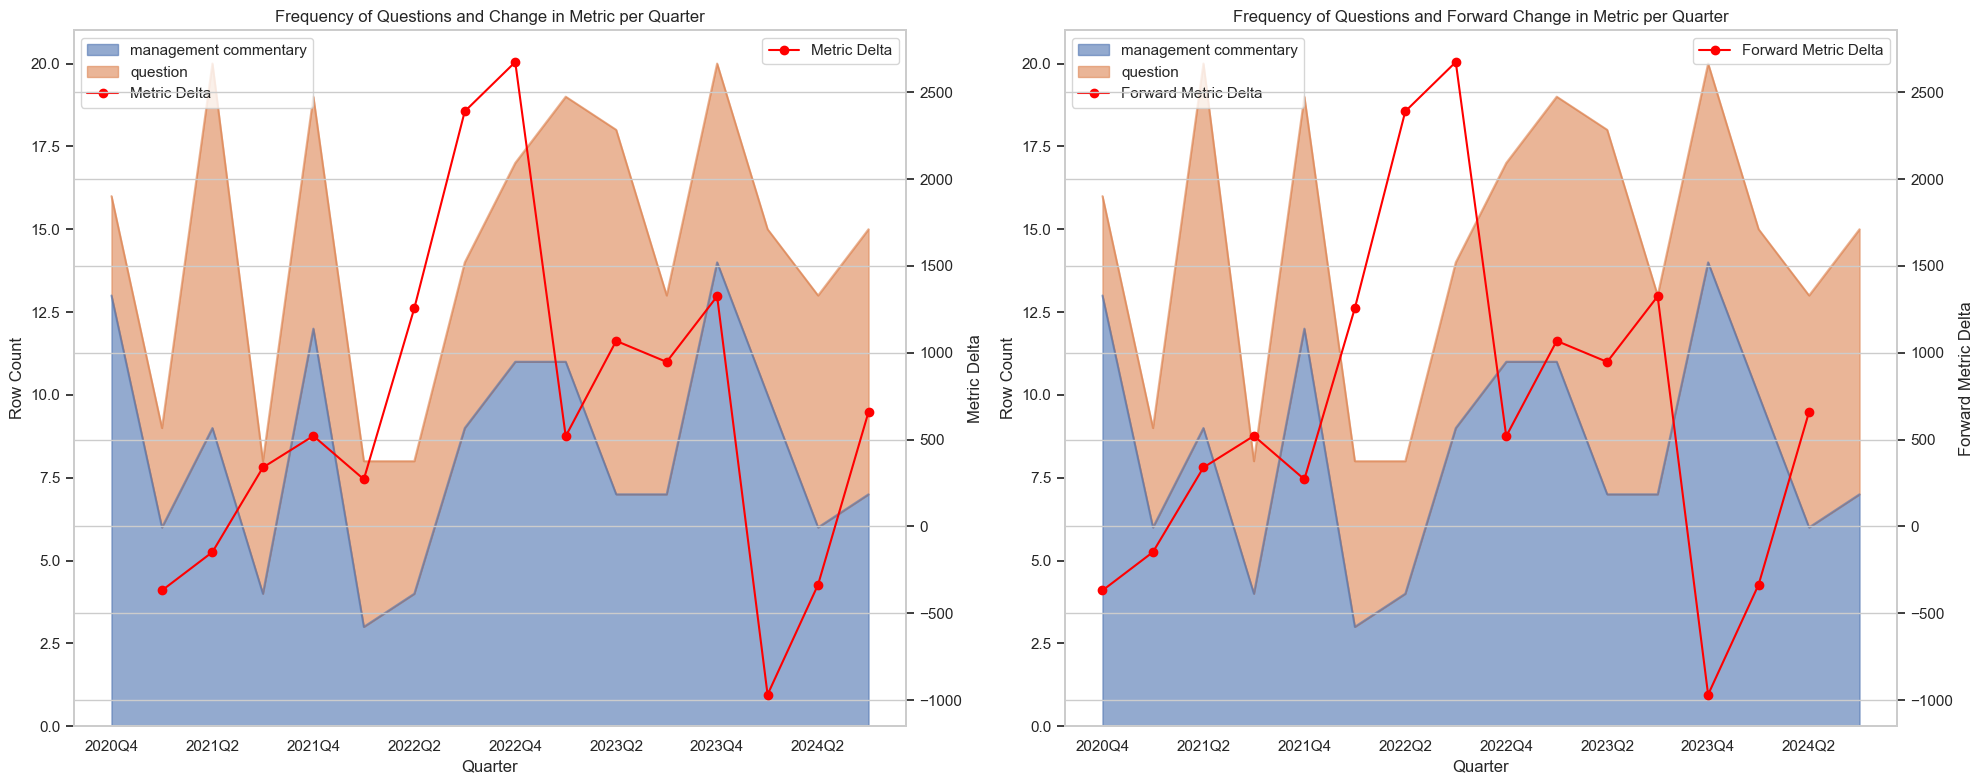

Report Analysis Completed.

Starting Text Preprocessing...
Text Preprocessing Completed.

Starting Word Frequency Analysis...


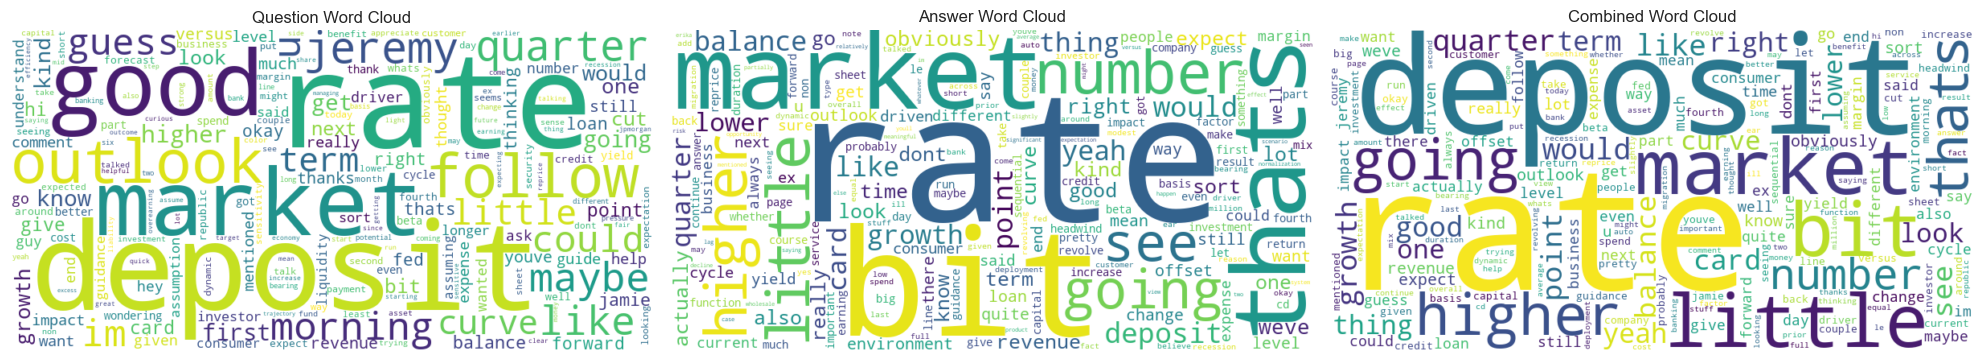

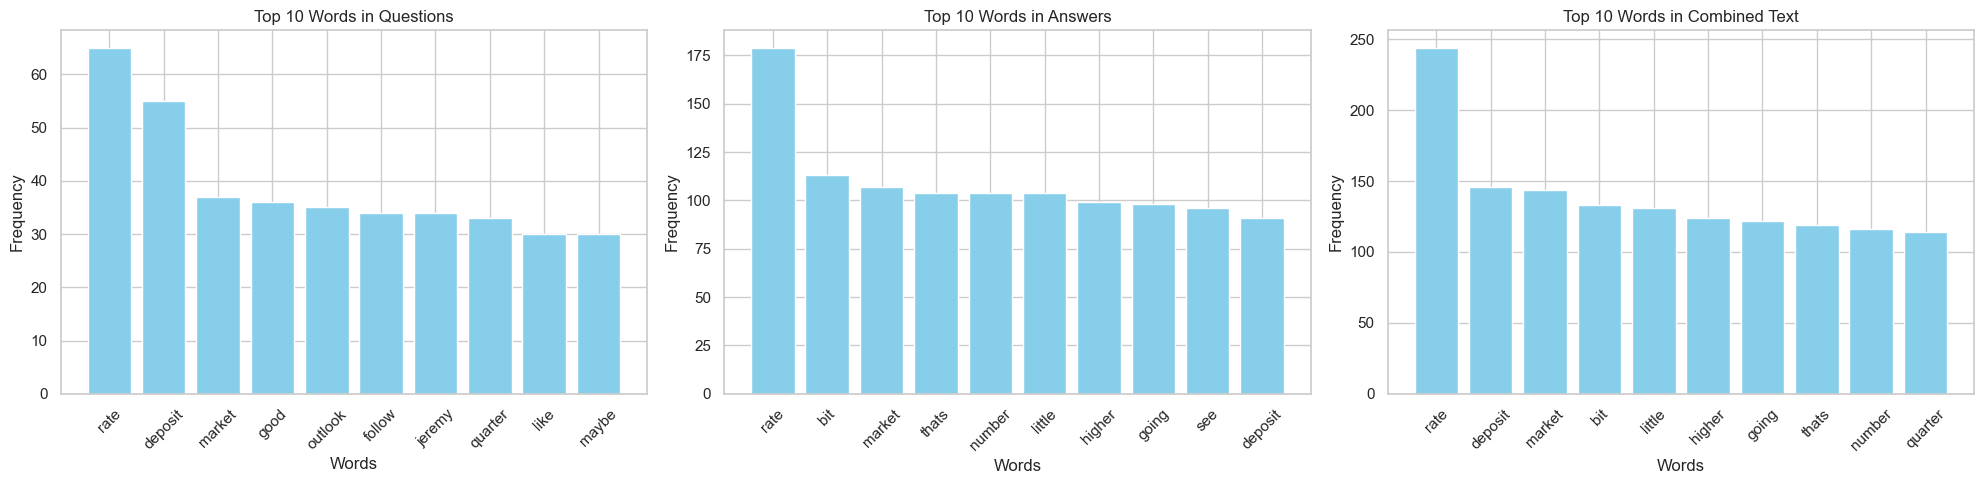

Word Frequency Analysis Completed.

Starting Sentiment Analysis with ProsusAI/finbert...
ProsusAI/finbert Sentiment Analysis Completed.

Starting Sentiment Analysis with FinBERT-pretrain...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FinBERT-pretrain Sentiment Analysis Completed.

Starting Sentiment Analysis with FinBERT-tone...
FinBERT-tone Sentiment Analysis Completed.

Starting Sentiment Analysis with Financial-RoBERTa...
Financial-RoBERTa Sentiment Analysis Completed.

Merging GPT-4 Sentiment Analysis Results...
Merging Completed.

Plotting Sentiment Distributions...


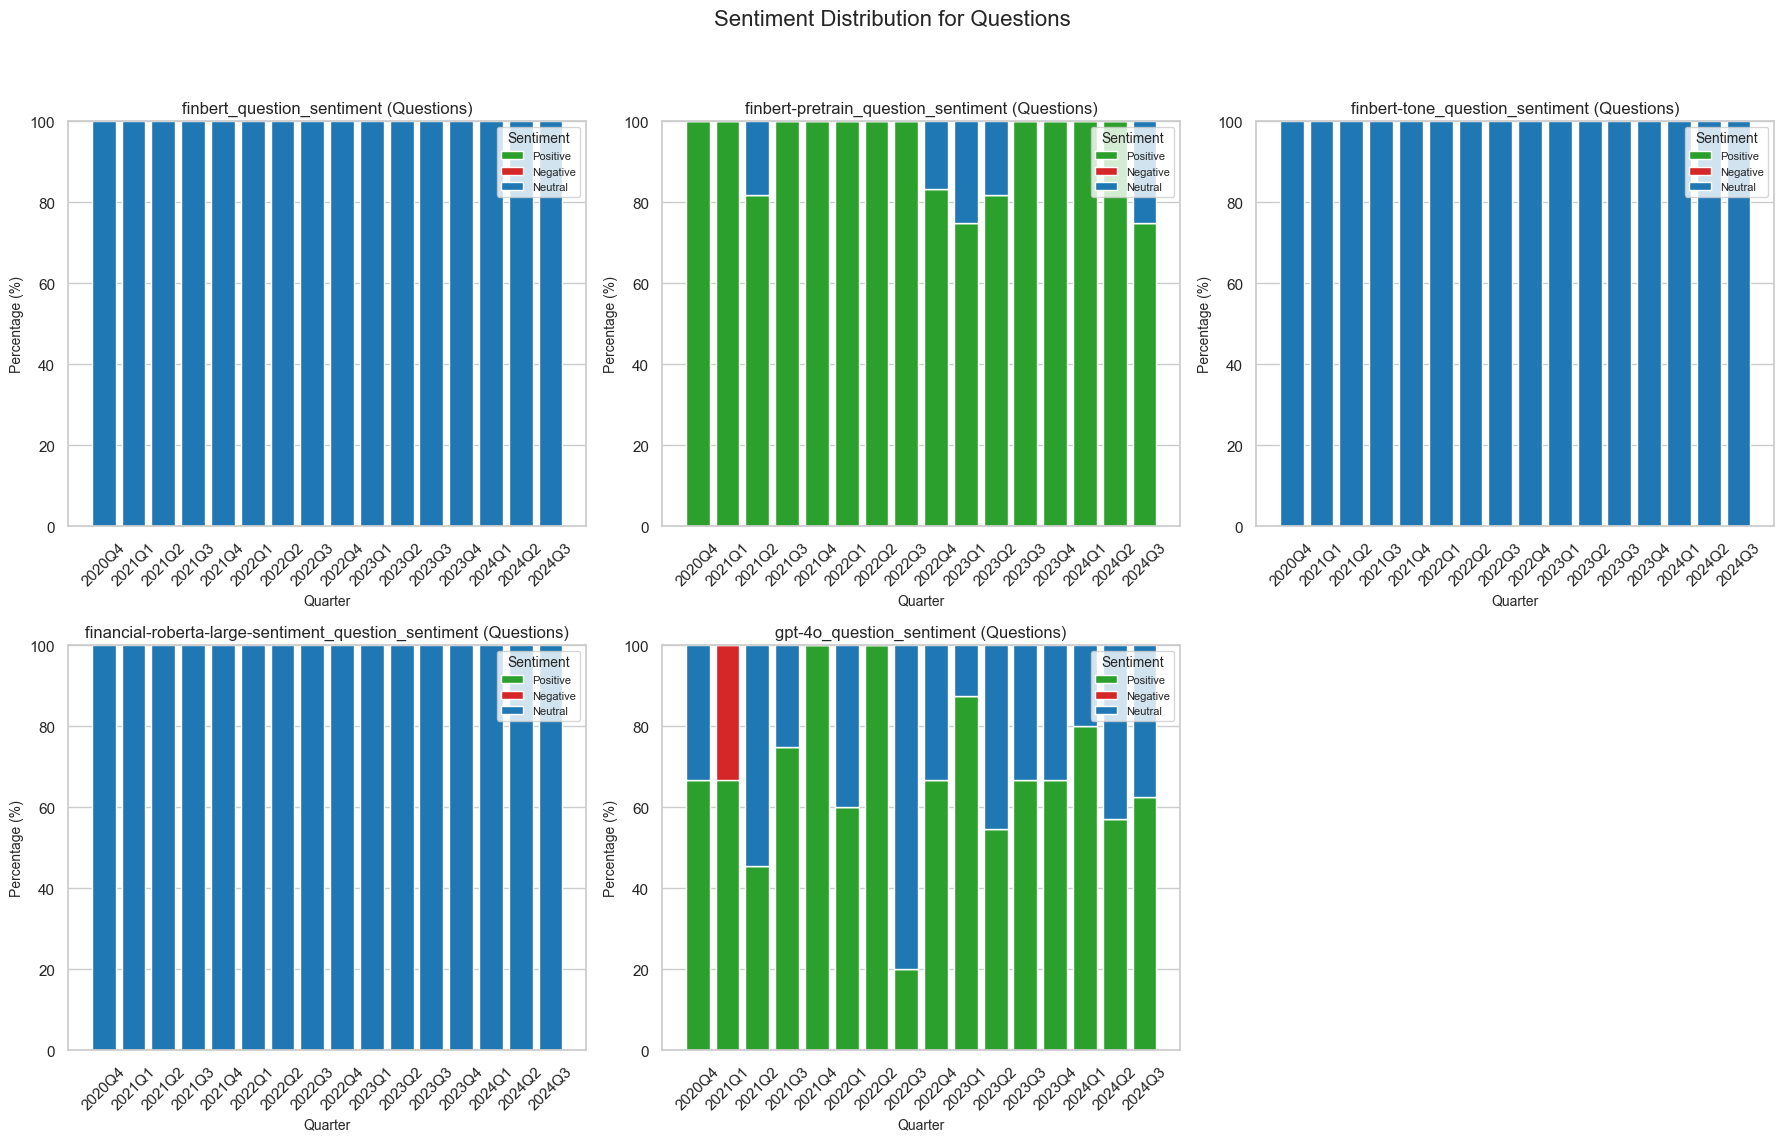

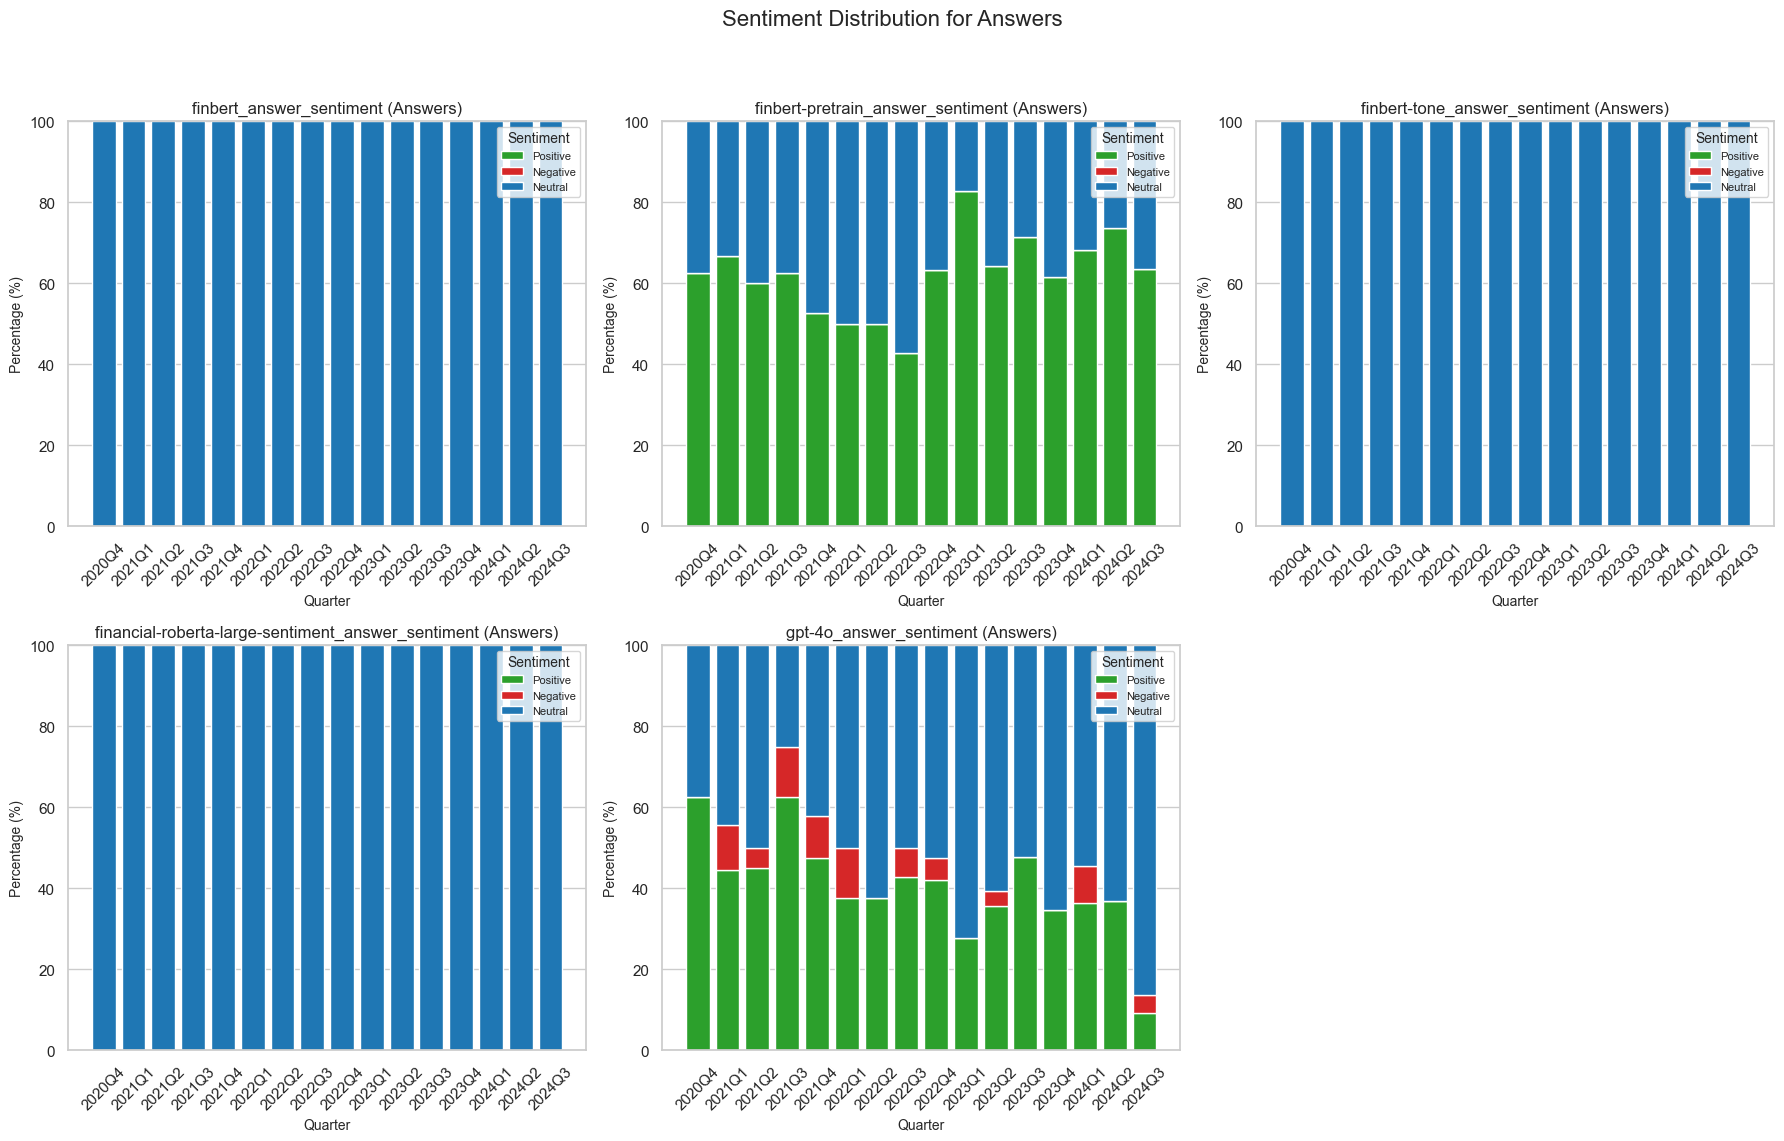

Sentiment Distributions Plotted.

Aggregating Sentiments Quarterly with Weighted Averages...
Aggregation Completed.

Analyzing Correlations Between Ratio Deltas and Sentiment Scores...


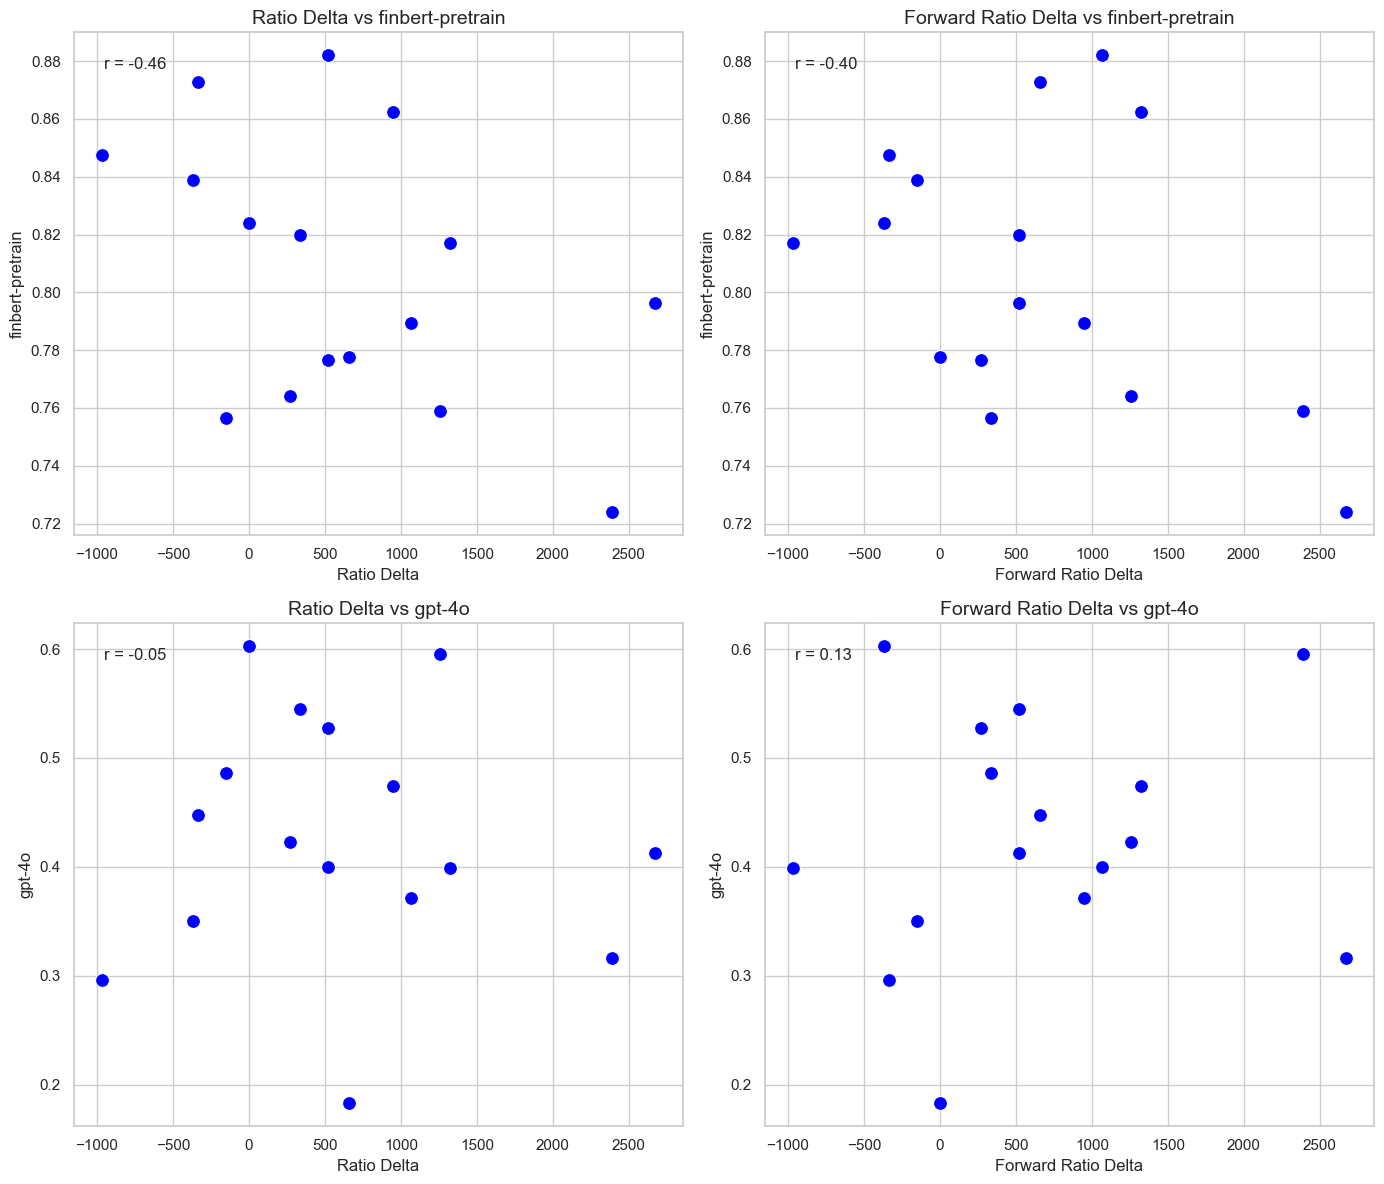

Correlation Analysis Completed.



,Model,Correlation with Ratio Delta,Correlation with Forward Ratio Delta
0,gpt-4o,-0.052834,0.131256


In [205]:
if __name__ == "__main__":
    main_analyzer = MainAnalyzer()
    main_analyzer.run()

correlation_df

In [211]:
# Global variables
master_df = pd.read_csv("jpm_rotce_data.csv")
gpt4_df = pd.read_csv("jpm_rotce_gpt-4o_sentiment_analysis.csv")
exclude_words = {'management', 'commentary', 'rotce', 'net', 'interest', 'income','nii','think','question','year','billion','youre'}

# Convert all column names in master_df and gpt4_df to lowercase and strip whitespace
master_df.columns = master_df.columns.str.lower().str.strip()
gpt4_df.columns = gpt4_df.columns.str.lower().str.strip()

Starting Report Analysis...


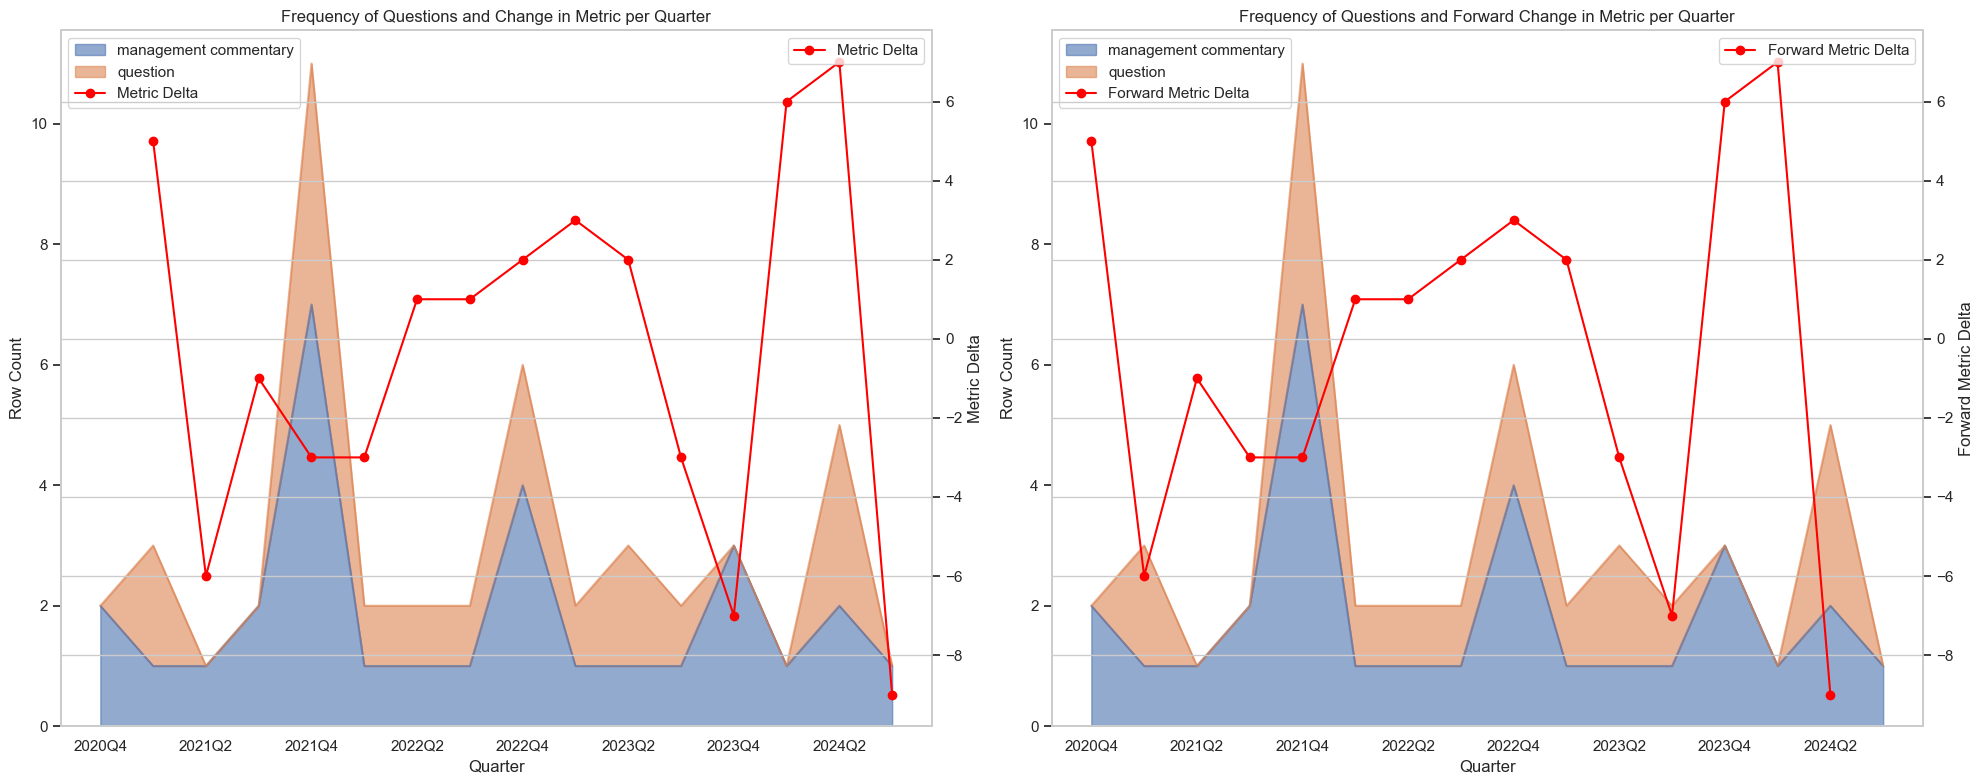

Report Analysis Completed.

Starting Text Preprocessing...
Text Preprocessing Completed.

Starting Word Frequency Analysis...


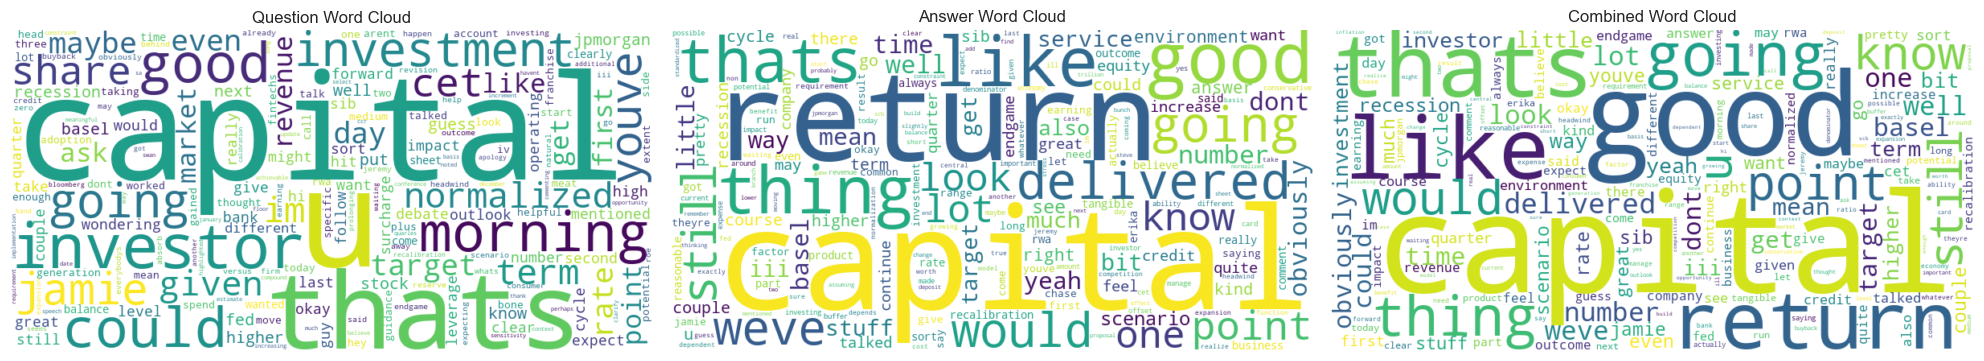

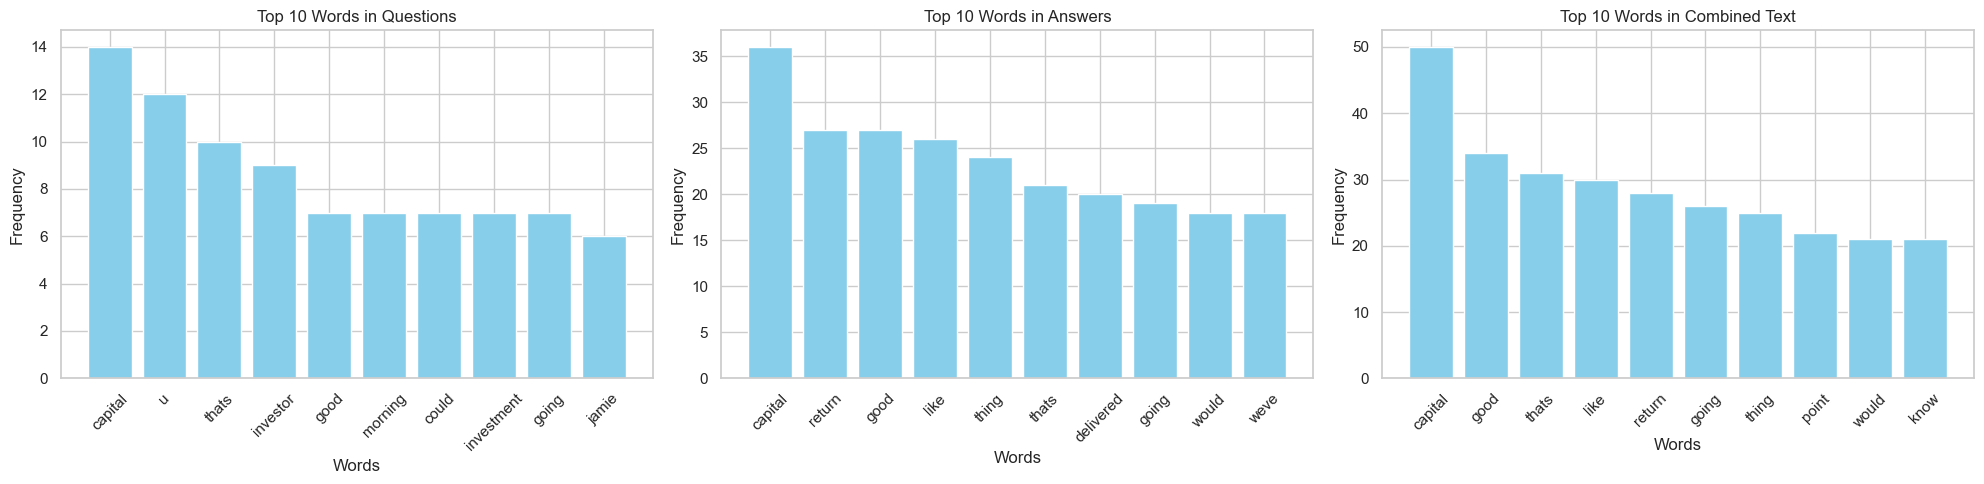

Word Frequency Analysis Completed.

Starting Sentiment Analysis with ProsusAI/finbert...
ProsusAI/finbert Sentiment Analysis Completed.

Starting Sentiment Analysis with FinBERT-pretrain...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FinBERT-pretrain Sentiment Analysis Completed.

Starting Sentiment Analysis with FinBERT-tone...
FinBERT-tone Sentiment Analysis Completed.

Starting Sentiment Analysis with Financial-RoBERTa...
Financial-RoBERTa Sentiment Analysis Completed.

Merging GPT-4 Sentiment Analysis Results...
Merging Completed.

Re-ensuring 'ratio' Column is Numeric After Merging...
'ratio' Column dtype after re-conversion: int64
'ratio' Column head after re-conversion:
0    24
1    24
2    29
3    29
4    29
Name: ratio, dtype: int64

Plotting Sentiment Distributions...


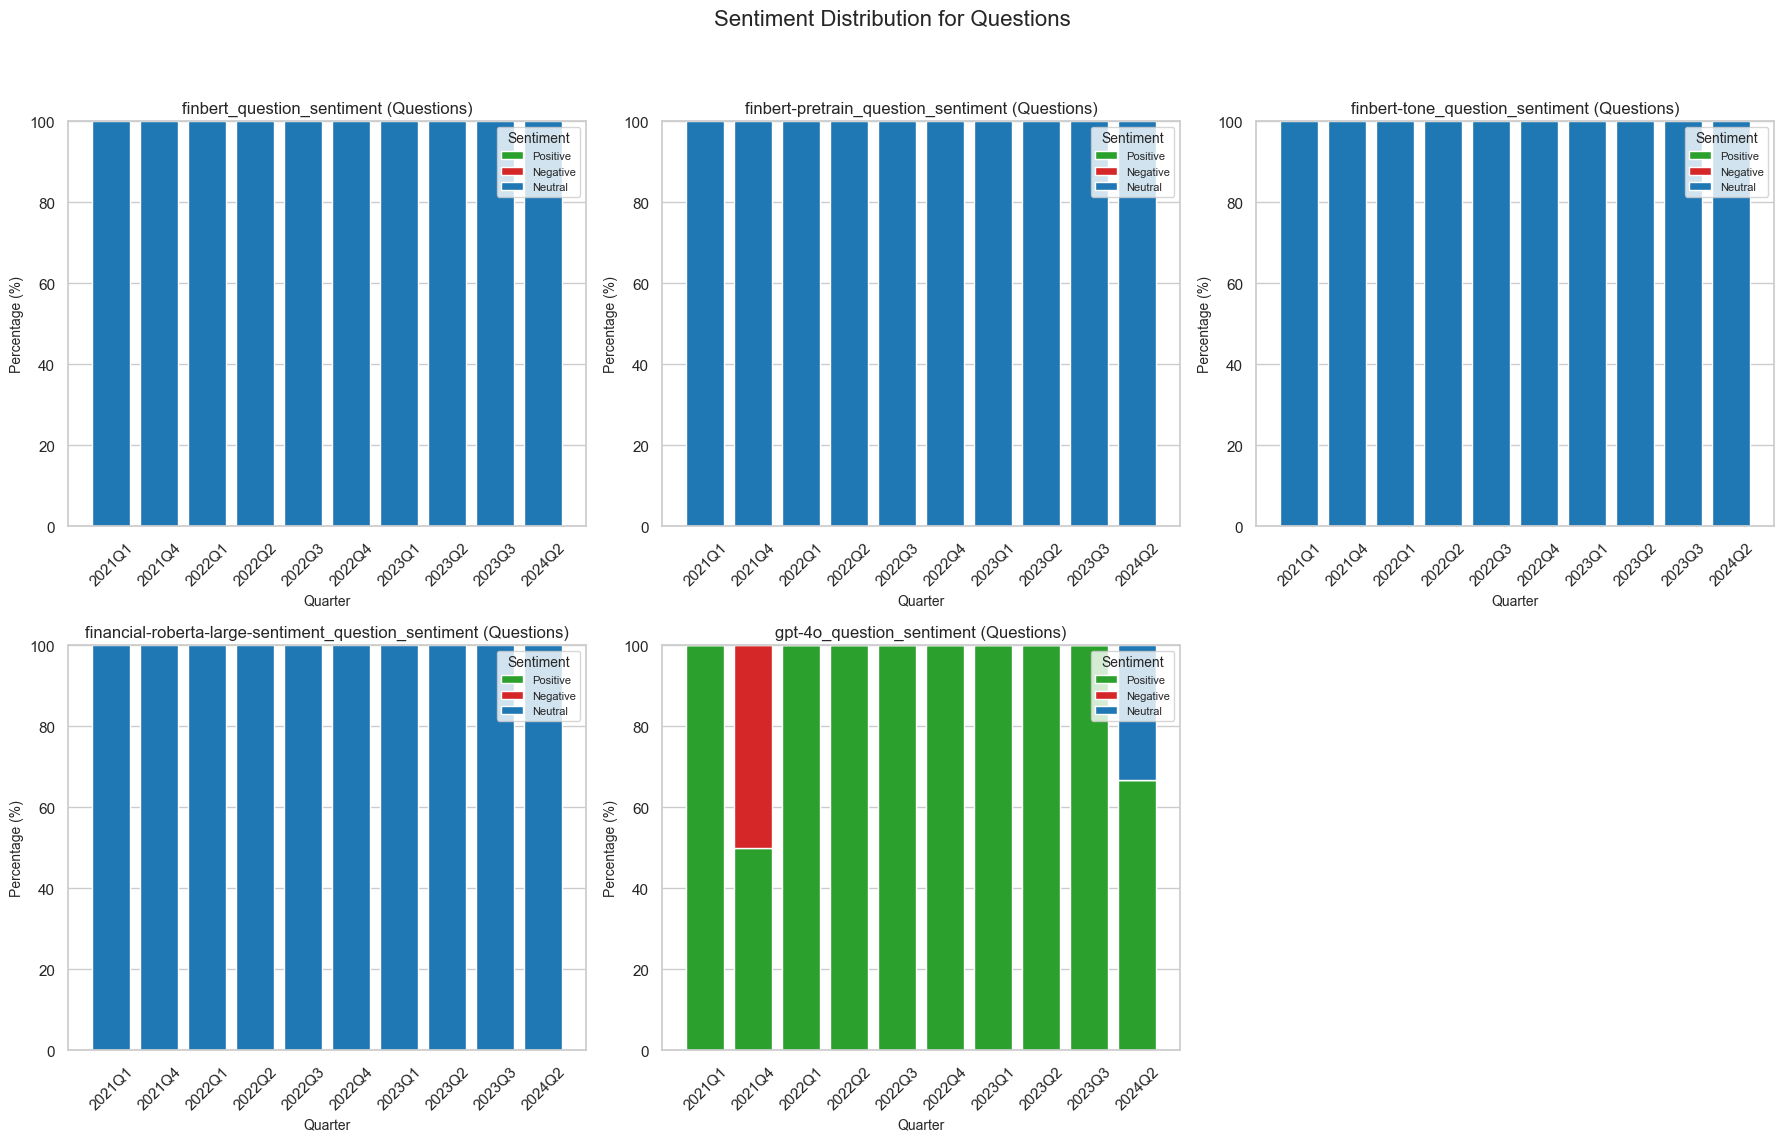

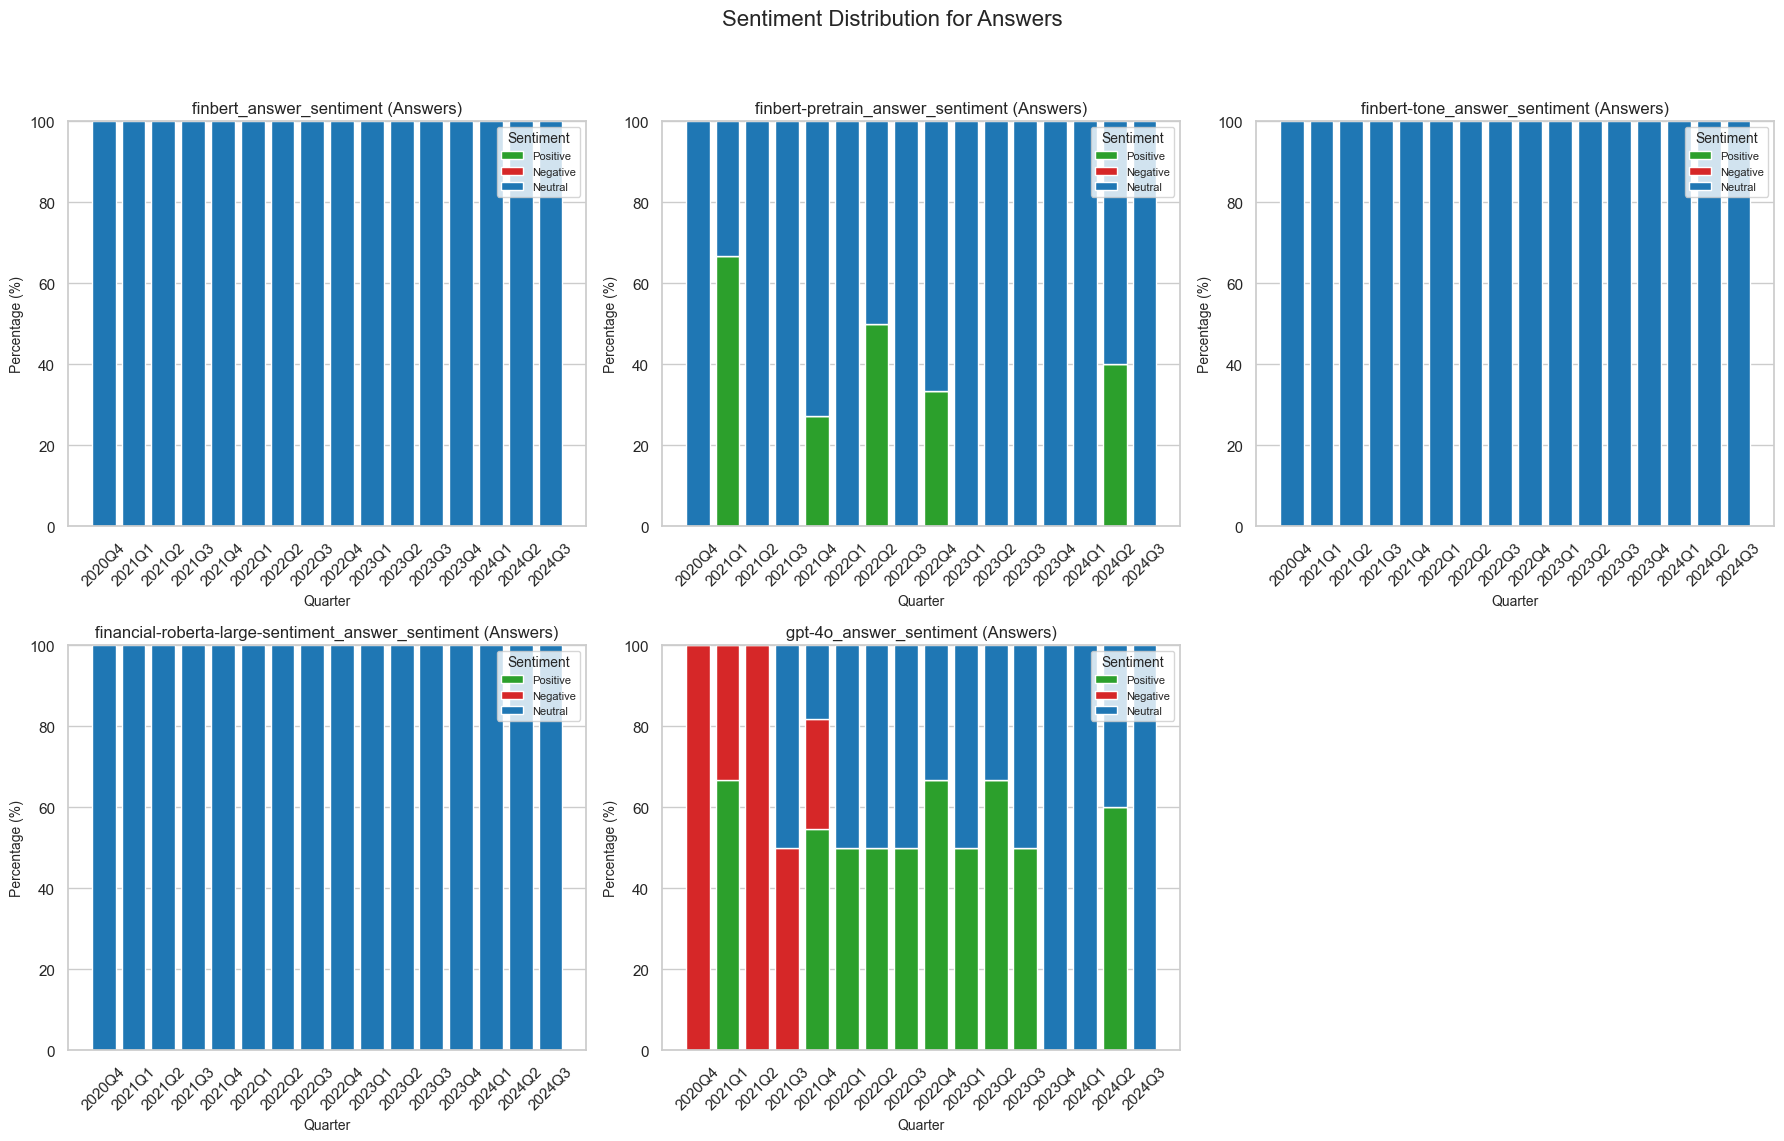

Sentiment Distributions Plotted.

Aggregating Sentiments Quarterly with Weighted Averages...
Aggregation Completed.

Analyzing Correlations Between Ratio Deltas and Sentiment Scores...


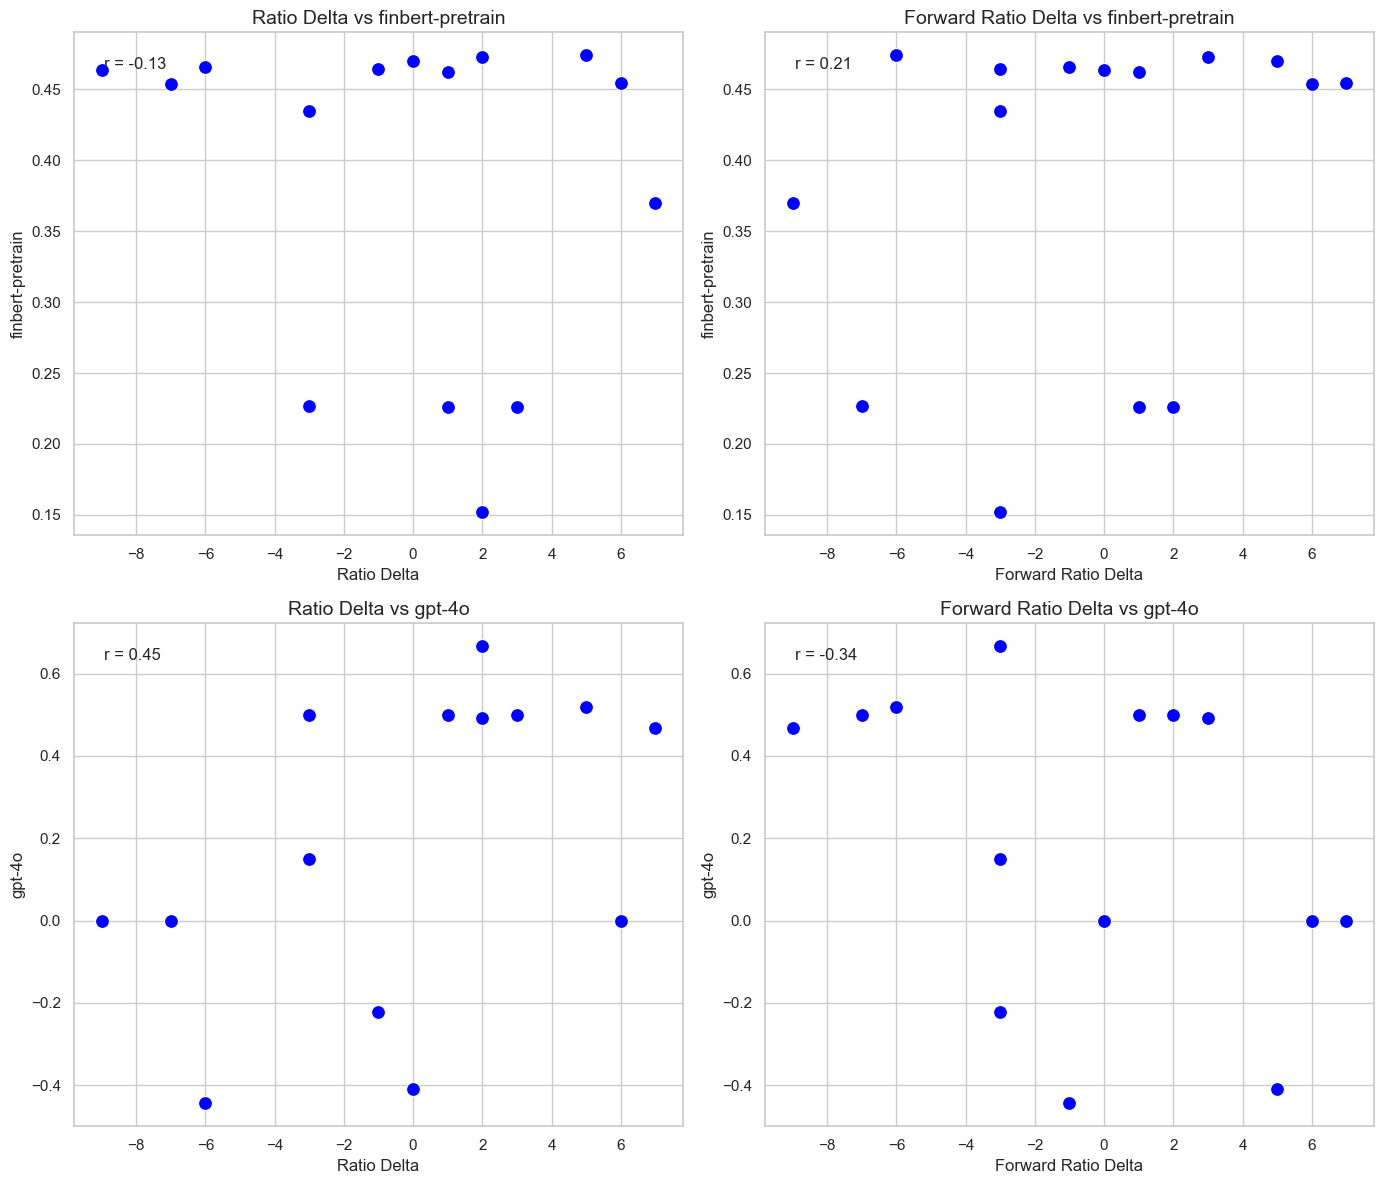

Correlation Analysis Completed.



,Model,Correlation with Ratio Delta,Correlation with Forward Ratio Delta
0,gpt-4o,-0.052834,0.131256


In [212]:
if __name__ == "__main__":
    main_analyzer = MainAnalyzer()
    main_analyzer.run()

correlation_df